#Load libraries

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno # visualizing missing data
import impyute as impy # for imputing missing data with EM algorithm

import statsmodels.api as sm # for modeling
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import ProbPlot
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Section 1: read in the data from gdp_per_capita, life_expectancy, and literacy rate files. Join them together.

In [35]:
#- read in the data from gdp_per_capita, life_expectancy, and literacy rate files. Join them together.
gdp_per_capita = pd.read_csv('/content/drive/MyDrive/share_with_candidate/gdp_per_capita.csv', usecols=['country_name','gdp_per_capita'])
life_expectancy = pd.read_csv('/content/drive/MyDrive/share_with_candidate/life_expectancy.csv', usecols = ['country_name', 'life_expectancy'])
literacy_rate = pd.read_csv('/content/drive/MyDrive/share_with_candidate/literacy_rate.csv', usecols = ['country_name', 'literacy_rate'])
regions = pd.read_csv('/content/drive/MyDrive/share_with_candidate/regions.csv', usecols=['region_name'])
test = pd.read_csv('/content/drive/MyDrive/share_with_candidate/test_set.csv')
merged = gdp_per_capita.merge(life_expectancy,on='country_name').merge(literacy_rate,on='country_name')
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203 entries, 0 to 202
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country_name     203 non-null    object 
 1   gdp_per_capita   200 non-null    float64
 2   life_expectancy  203 non-null    float64
 3   literacy_rate    203 non-null    float64
dtypes: float64(3), object(1)
memory usage: 7.9+ KB


In [36]:
merged.describe()

,gdp_per_capita,life_expectancy,literacy_rate
count,200.000000,203.000000,203.000000
mean,8305.622272,73.750314,0.808210
std,11256.621108,7.226326,0.211303
min,238.990726,55.495000,0.036872
25%,1602.580046,68.056500,0.691973
50%,4243.712776,75.692705,0.895157
75%,9315.627125,78.822442,0.974470
max,85082.526860,87.179000,0.999999


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe88bb6c150>,
      dtype=object)

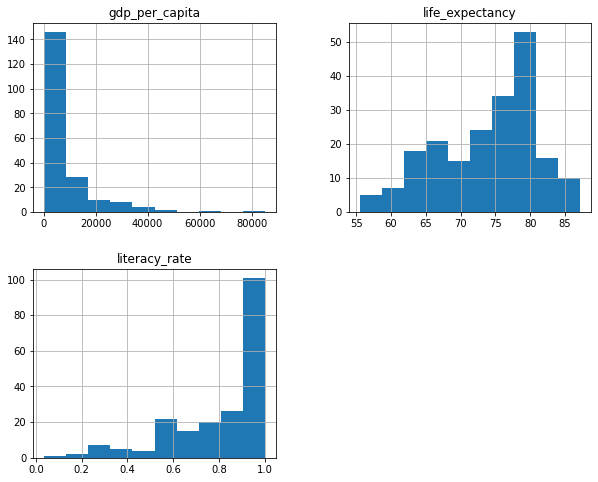

In [44]:
merged.hist(figsize=(10,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe88ba6aad0>,
      dtype=object)

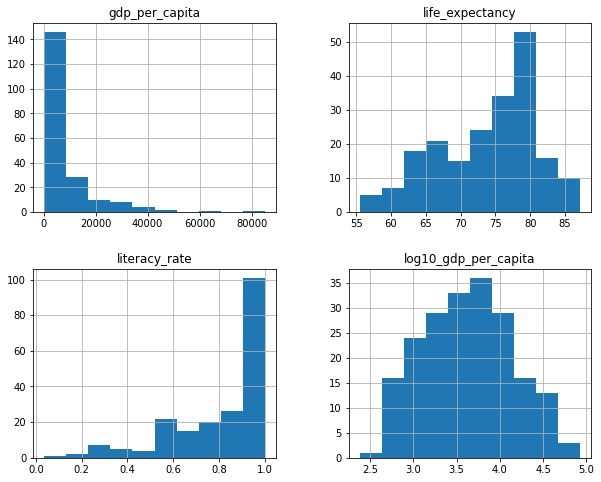

In [45]:
merged["log10_gdp_per_capita"] =  np.log10(merged['gdp_per_capita'])
merged.hist(figsize=(10,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe88b7baed0>,
      dtype=object)

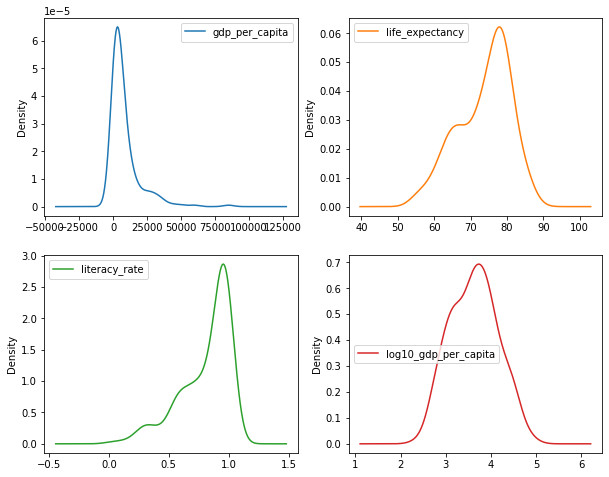

In [46]:
merged.plot(kind='density', subplots=True,figsize=(10,8), layout=(2,2), sharex=False)

# Section-2: create a training set that removes the regions in regions.csv and the countries in test_set.csv


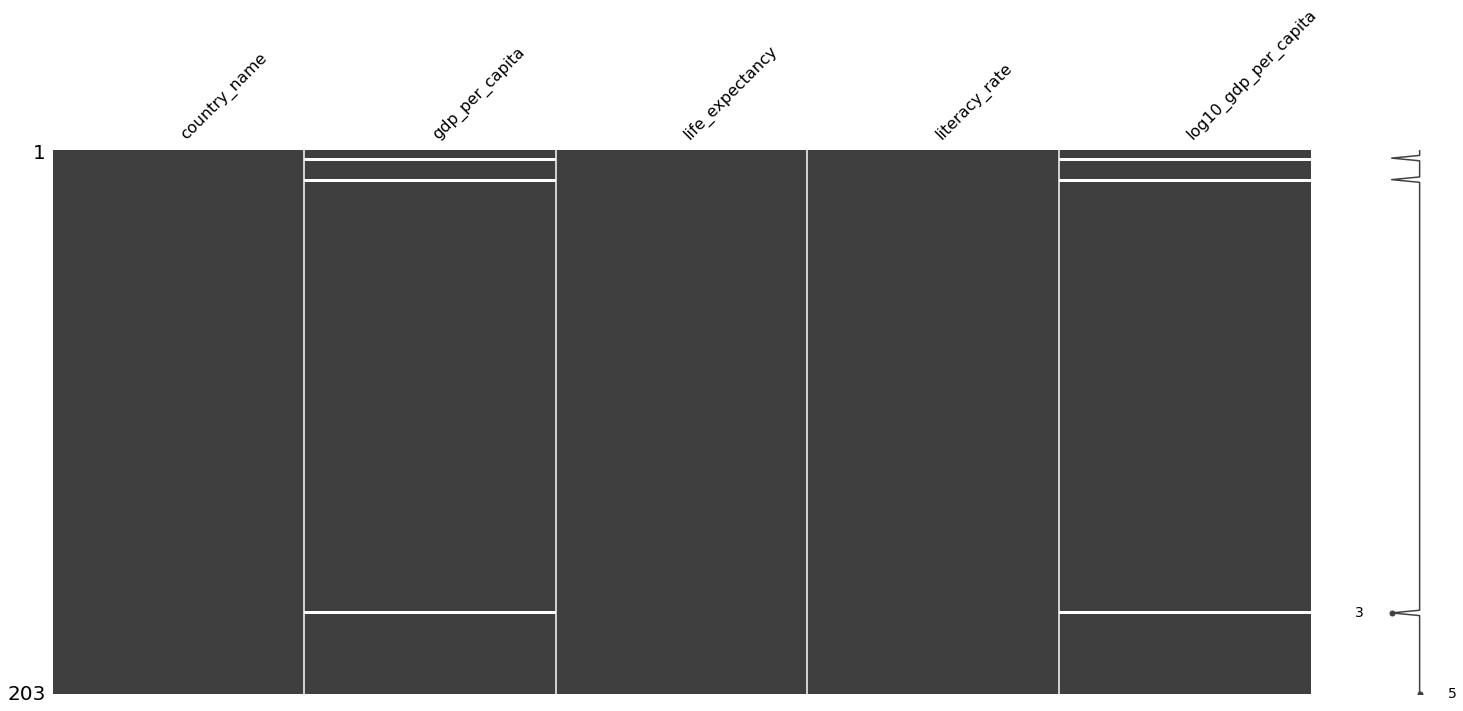

In [47]:
import missingno as msno
msno.matrix(merged)

In [48]:
gdp_per_capita[gdp_per_capita.isnull().any(axis=1)]

,country_name,gdp_per_capita
8,Antigua and Barbuda,NaN
19,Barbados,NaN
223,St. Vincent and the Grenadines,NaN


In [49]:
merged[merged.isnull().any(axis=1)]

,country_name,gdp_per_capita,life_expectancy,literacy_rate,log10_gdp_per_capita
3,Antigua and Barbuda,NaN,78.104,0.9942,NaN
11,Barbados,NaN,80.482,0.9960,NaN
172,St. Vincent and the Grenadines,NaN,75.131,0.9550,NaN


In [50]:
training_data = merged[~merged['country_name'].isin(regions['region_name'].values)]
training_data = training_data[~training_data['country_name'].isin(test['country_name'].values)]
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 0 to 202
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country_name          160 non-null    object 
 1   gdp_per_capita        157 non-null    float64
 2   life_expectancy       160 non-null    float64
 3   literacy_rate         160 non-null    float64
 4   log10_gdp_per_capita  157 non-null    float64
dtypes: float64(4), object(1)
memory usage: 7.5+ KB


In [51]:
training_data.describe()

,gdp_per_capita,life_expectancy,literacy_rate,log10_gdp_per_capita
count,157.000000,160.000000,160.000000,157.000000
mean,9051.126307,74.073475,0.817666,3.633911
std,12365.430433,7.534786,0.218989,0.548729
min,238.990726,55.495000,0.036872,2.378381
25%,1543.669258,68.473750,0.721690,3.188554
50%,4179.278066,76.177000,0.924594,3.621101
75%,10412.348980,79.511000,0.978552,4.017549
max,85082.526860,87.179000,0.999582,4.929840


In [52]:
import impyute as impy
em_imputed = impy.em(training_data[['life_expectancy',	'literacy_rate',	'log10_gdp_per_capita']].values)
training_data_2 = pd.DataFrame(em_imputed, columns = ['life_expectancy',	'literacy_rate',	'log10_gdp_per_capita'])
training_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   life_expectancy       160 non-null    float64
 1   literacy_rate         160 non-null    float64
 2   log10_gdp_per_capita  160 non-null    float64
dtypes: float64(3)
memory usage: 3.9 KB


#Section-3: fit a model to predict the literacy rate based on gdp_per_capita and life_expectancy

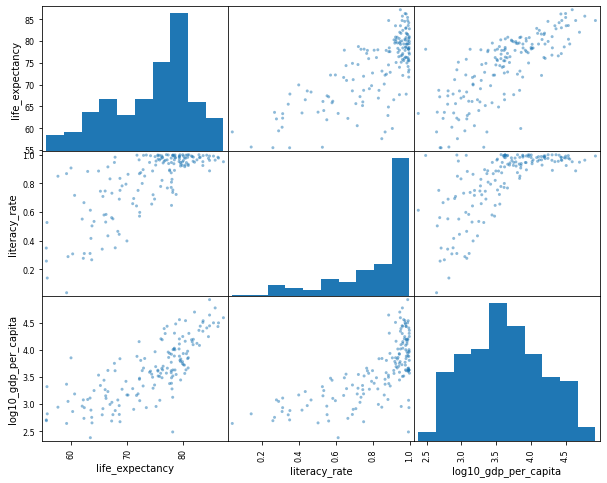

In [53]:
from pandas.plotting import scatter_matrix
scatter_matrix(training_data_2, figsize=(10,8))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

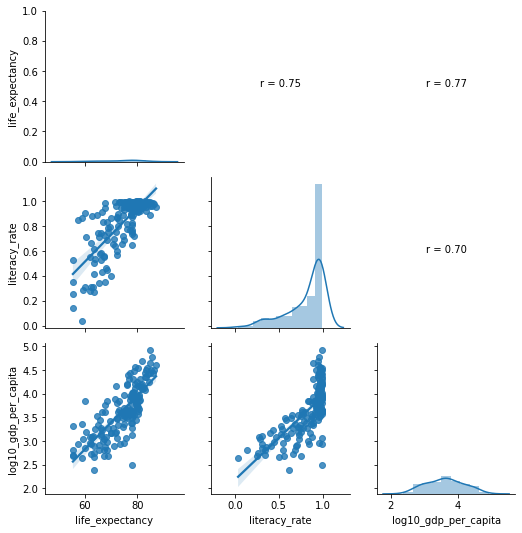

In [54]:
from scipy.stats import pearsonr
def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()

g = sns.PairGrid(training_data_2)
g.map_diag(sns.distplot)
g.map_lower(sns.regplot)
g.map_upper(reg_coef)

In [55]:
vif_data = pd.DataFrame()
X_variables = training_data_2
vif_data["feature"] = X_variables.columns
vif_data["VIF"] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]
vif_data

,feature,VIF
0,life_expectancy,109.728953
1,literacy_rate,29.239880
2,log10_gdp_per_capita,119.557371


In [120]:
def graph(formula, x_range, label=None):
    """
    Helper function for plotting cook's distance lines
    """
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')


def diagnostic_plots(X, y, model_fit=None):
  """
  Function to reproduce the 4 base plots of an OLS model in R.

  ---
  Inputs:

  X: A numpy array or pandas dataframe of the features to use in building the linear regression model

  y: A numpy array or pandas series/dataframe of the target variable of the linear regression model

  model_fit [optional]: a statsmodel.api.OLS model after regressing y on X. If not provided, will be
                        generated from X, y
  """

  if not model_fit:
      model_fit = sm.OLS(y, sm.add_constant(X)).fit()

  # create dataframe from X, y for easier plot handling
  dataframe = pd.concat([X, y], axis=1)

  # model values
  model_fitted_y = model_fit.fittedvalues
  # model residuals
  model_residuals = model_fit.resid
  # normalized residuals
  model_norm_residuals = model_fit.get_influence().resid_studentized_internal
  # absolute squared normalized residuals
  model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
  # absolute residuals
  model_abs_resid = np.abs(model_residuals)
  # leverage, from statsmodels internals
  model_leverage = model_fit.get_influence().hat_matrix_diag
  # cook's distance, from statsmodels internals
  model_cooks = model_fit.get_influence().cooks_distance[0]

  plot_lm_1 = plt.figure()
  plot_lm_1.axes[0] = sns.residplot(model_fitted_y, dataframe.columns[-1], data=dataframe,
                            lowess=True,
                            scatter_kws={'alpha': 0.5},
                            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

  plot_lm_1.axes[0].set_title('Residuals vs Fitted')
  plot_lm_1.axes[0].set_xlabel('Fitted values')
  plot_lm_1.axes[0].set_ylabel('Residuals');

  # annotations
  abs_resid = model_abs_resid.sort_values(ascending=False)
  abs_resid_top_3 = abs_resid[:3]
  for i in abs_resid_top_3.index:
      plot_lm_1.axes[0].annotate(i,
                                 xy=(model_fitted_y[i],
                                     model_residuals[i]));

  QQ = ProbPlot(model_norm_residuals)
  plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
  plot_lm_2.axes[0].set_title('Normal Q-Q')
  plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
  plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
  # annotations
  abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
  abs_norm_resid_top_3 = abs_norm_resid[:3]
  for r, i in enumerate(abs_norm_resid_top_3):
      plot_lm_2.axes[0].annotate(i,
                                 xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                     model_norm_residuals[i]));

  plot_lm_3 = plt.figure()
  plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
  sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
  plot_lm_3.axes[0].set_title('Scale-Location')
  plot_lm_3.axes[0].set_xlabel('Fitted values')
  plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

  # annotations
  abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
  abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
  for i in abs_norm_resid_top_3:
      plot_lm_3.axes[0].annotate(i,
                                 xy=(model_fitted_y[i],
                                     model_norm_residuals_abs_sqrt[i]));


  plot_lm_4 = plt.figure();
  plt.scatter(model_leverage, model_norm_residuals, alpha=0.5);
  sns.regplot(model_leverage, model_norm_residuals,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
  plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
  plot_lm_4.axes[0].set_ylim(-3, 5)
  plot_lm_4.axes[0].set_title('Residuals vs Leverage')
  plot_lm_4.axes[0].set_xlabel('Leverage')
  plot_lm_4.axes[0].set_ylabel('Standardized Residuals');

  # annotations
  leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
  for i in leverage_top_3:
      plot_lm_4.axes[0].annotate(i,
                                 xy=(model_leverage[i],
                                     model_norm_residuals[i]));

  p = len(model_fit.params) # number of model parameters
  graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x),
        np.linspace(0.001, max(model_leverage), 50),
        'Cook\'s distance') # 0.5 line
  graph(lambda x: np.sqrt((1 * p * (1 - x)) / x),
        np.linspace(0.001, max(model_leverage), 50)) # 1 line
  plot_lm_4.legend(loc='upper right');

In [112]:
X = sm.add_constant(training_data_2[['log10_gdp_per_capita', 'life_expectancy']].reset_index(drop = True))
y = training_data_2[['literacy_rate']].reset_index(drop = True)
olsmod = sm.OLS(y, X)
olsres = olsmod.fit()
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:          literacy_rate   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     114.6
Date:                Mon, 11 Apr 2022   Prob (F-statistic):           2.05e-31
Time:                        00:35:50   Log-Likelihood:                 88.480
No. Observations:                 160   AIC:                            -171.0
Df Residuals:                     157   BIC:                            -161.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.7195 

In [125]:
olsres.predict()

array([0.92078686, 0.86606888, 0.62341879, 0.74264515, 0.94309307,
       0.88493635, 0.98791285, 0.8386613 , 0.9643413 , 0.78625514,
       0.91454795, 0.9192738 , 0.87302341, 0.59627094, 0.77205597,
       0.80912412, 0.92325743, 0.81432714, 0.92450029, 0.95994722,
       0.92907515, 0.55978861, 0.51000043, 0.8332119 , 0.7337582 ,
       0.5639958 , 1.13180685, 0.42987623, 0.44721379, 1.00201654,
       0.94198024, 0.91892886, 0.64299731, 0.53535817, 0.65505459,
       1.00431375, 0.5638261 , 0.99284222, 0.9599491 , 1.04864325,
       0.89548068, 0.91873469, 0.81348998, 0.86887726, 0.63368194,
       0.63840611, 1.03596237, 0.66934228, 0.65756025, 0.76249996,
       0.57214232, 0.87932691, 0.65159598, 1.04755463, 0.87171494,
       1.06822061, 0.86847068, 0.5742064 , 0.52018729, 0.82917974,
       0.63821853, 0.84059275, 0.9648171 , 0.73089756, 0.81193851,
       0.84630089, 0.79585141, 1.09796837, 1.09132897, 0.85212037,
       0.90599766, 0.70116349, 0.94688628, 0.77774483, 0.72893

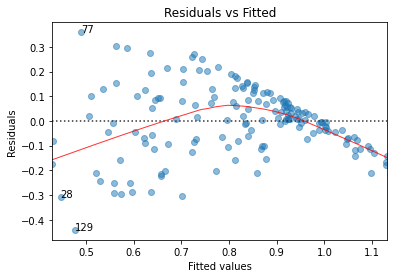

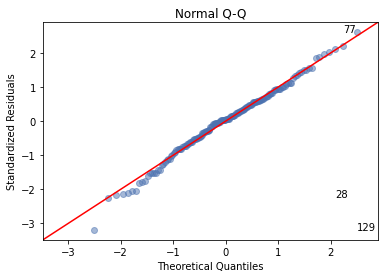

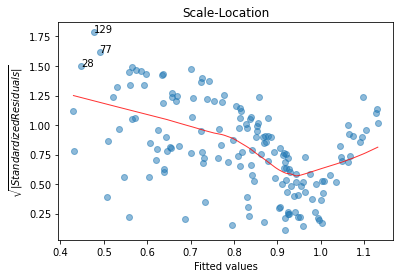

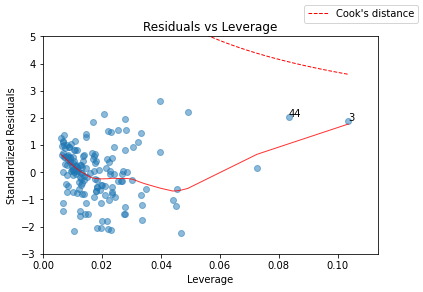

In [123]:
diagnostic_plots(X, y, olsres)

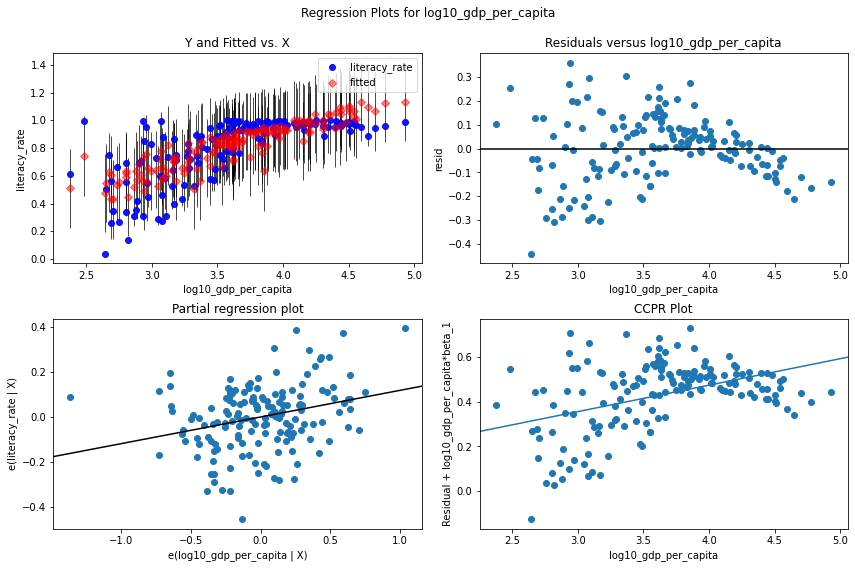

In [116]:
#define figure size
fig = plt.figure(figsize=(12,8))

#produce regression plots
fig = sm.graphics.plot_regress_exog(olsres, "log10_gdp_per_capita", fig=fig)

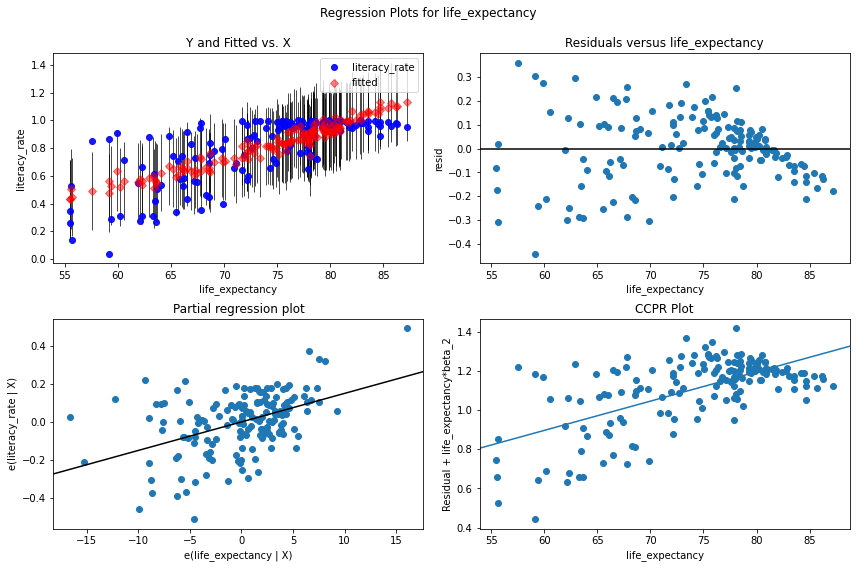

In [117]:
#define figure size
fig = plt.figure(figsize=(12,8))

#produce regression plots
fig = sm.graphics.plot_regress_exog(olsres, "life_expectancy", fig=fig)

#Prediction on Test Data

In [148]:
X_test = test.merge(gdp_per_capita, on = 'country_name').merge(life_expectancy,on='country_name').merge(literacy_rate,on='country_name')
X_test["log10_gdp_per_capita"] =  np.log10(X_test['gdp_per_capita'])
X_t = sm.add_constant(X_test[['log10_gdp_per_capita', 'life_expectancy']])

predictions = olsres.get_prediction(X_t)
predictions.summary_frame(alpha=0.05)[["mean","mean_ci_lower",	"mean_ci_upper" ]]

,mean,mean_ci_lower,mean_ci_upper
0,0.527057,0.480181,0.573932
1,0.768939,0.737200,0.800679
2,0.853719,0.830561,0.876877


In [150]:
results_df = pd.concat([X_test, predictions.summary_frame(alpha=0.05)[["mean","mean_ci_lower",	"mean_ci_upper" ]]], axis=1)
results_df.rename(columns = {'mean':'literacy_rate_predcition (mean)', 'mean_ci_lower':'literacy_rate_predcition (lower)','mean_ci_upper':'literacy_rate_predcition (upper)'}, inplace = True)

In [151]:
results_df

,country_name,gdp_per_capita,life_expectancy,literacy_rate,log10_gdp_per_capita,literacy_rate_predcition (mean),literacy_rate_predcition (lower),literacy_rate_predcition (upper)
0,Mali,862.453019,60.085,0.220785,2.935735,0.527057,0.480181,0.573932
1,Uzbekistan,1750.697113,73.829,0.999999,3.243211,0.768939,0.737200,0.800679
2,Jamaica,4664.530242,76.118,0.927000,3.668808,0.853719,0.830561,0.876877


In [152]:
results_df.to_csv("Test_dataset_with_output.csv")

In [153]:
from google.colab import files
files.download("Test_dataset_with_output.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [154]:
training_data.to_csv("training_data_with_missing_value.csv")
training_data_2.to_csv("training_data_with_imputation.csv")
files.download("training_data_with_missing_value.csv")
files.download("training_data_with_imputation.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>